# v21 Training - Korean-Optimized SPLADE with skt/A.X-Encoder-base

This notebook trains the v21 Korean-English cross-lingual SPLADE model using **Korean-optimized** vocabulary.

## v21 Key Changes

| Feature | v19 | v21 |
|---------|-----|-----|
| Base Model | xlm-roberta-large | **skt/A.X-Encoder-base** |
| Vocab Size | 250,002 | **50,000** |
| Model Size | 560M | ~110M |
| Korean Vocab | Multilingual (shared) | **Korean-optimized** |

## Why skt/A.X-Encoder-base?

According to [recent research](https://huggingface.co/blog/yjoonjang/vocabulary-is-the-most-important-element-in-splade):

| Model | Vocab Size | Recall@10 | NDCG@10 |
|-------|-----------|-----------|---------||
| **skt/A.X-Encoder-base** | 50,000 | **0.731** | **0.6618** |
| klue/roberta-base | 32,000 | 0.6751 | 0.6234 |
| Alibaba GTE multilingual | 250,048 | 0.61 | 0.5224 |
| jhu-clsp/mmBERT-base | 256,000 | 0.023 | 0.0103 |

## Architecture

```
┌─────────────────────┐     Distillation     ┌─────────────────────┐
│    Dense Teacher    │  ─────────────────▶  │   Sparse Student    │
│     (BGE-M3)        │    soft labels       │  (skt/A.X-Encoder)  │
└─────────────────────┘                      └─────────────────────┘
```

In [1]:
import sys
from pathlib import Path

def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import json
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from transformers import AutoTokenizer, AutoModelForMaskedLM, get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True
GPU: NVIDIA GB10
GPU Memory: 128.5 GB


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


## 1. Configuration

In [3]:
# Training Configuration
CONFIG = {
    # Model - Korean-optimized encoder
    "model_name": "skt/A.X-Encoder-base",  # Korean-English bilingual, 50K vocab
    "max_length": 64,
    
    # Teacher model for Knowledge Distillation
    "teacher_model": "BAAI/bge-m3",  # Best cross-lingual teacher

    # Data
    "data_path": PROJECT_ROOT / "dataset" / "v21_skt_encoder" / "term_mappings.jsonl",

    # Training
    "batch_size": 64,
    "gradient_accumulation_steps": 2,
    "num_epochs": 15,
    "learning_rate": 5e-6,  # Slightly higher LR for smaller model
    "warmup_ratio": 0.1,
    "max_grad_norm": 1.0,

    # Loss weights
    "lambda_self": 3.0,         # Korean source preservation
    "lambda_ko_target": 2.0,    # Korean synonym activation
    "lambda_en_target": 12.0,   # English translation
    "lambda_margin": 2.0,       # Margin loss for minimum activation
    "lambda_distill": 1.5,      # Knowledge distillation
    "lambda_flops": 5e-5,       # FLOPS regularization (auto noise suppression)
    "target_margin": 2.0,

    # Mixed precision
    "use_fp16": True,

    # Output
    "output_dir": PROJECT_ROOT / "outputs" / "v21_skt_encoder",
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\n*** Base Model: skt/A.X-Encoder-base (Korean-optimized, 50K vocab) ***")

Training Configuration:
  model_name: skt/A.X-Encoder-base
  max_length: 64
  teacher_model: BAAI/bge-m3
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder/term_mappings.jsonl
  batch_size: 64
  gradient_accumulation_steps: 2
  num_epochs: 15
  learning_rate: 5e-06
  warmup_ratio: 0.1
  max_grad_norm: 1.0
  lambda_self: 3.0
  lambda_ko_target: 2.0
  lambda_en_target: 12.0
  lambda_margin: 2.0
  lambda_distill: 1.5
  lambda_flops: 5e-05
  target_margin: 2.0
  use_fp16: True
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21_skt_encoder

*** Base Model: skt/A.X-Encoder-base (Korean-optimized, 50K vocab) ***


## 2. SPLADE Model for skt/A.X-Encoder-base

In [4]:
class SPLADEModel(nn.Module):
    """
    SPLADE model using skt/A.X-Encoder-base for Korean sparse retrieval.
    
    Key features:
    - Uses MLM head for vocabulary expansion
    - Korean-optimized vocabulary (50K tokens)
    - log(1 + ReLU(x)) activation for sparsity
    """

    def __init__(self, model_name: str = "skt/A.X-Encoder-base"):
        super().__init__()
        
        # Load pretrained model with MLM head
        self.model = AutoModelForMaskedLM.from_pretrained(model_name)
        self.config = self.model.config
        
        # ReLU for sparsity
        self.relu = nn.ReLU()
        
        print(f"Loaded {model_name}")
        print(f"  Vocab size: {self.config.vocab_size:,}")
        print(f"  Hidden size: {self.config.hidden_size}")

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ):
        """
        Forward pass with vocabulary expansion.
        
        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]
        
        Returns:
            sparse_repr: [batch_size, vocab_size]
            token_weights: [batch_size, seq_len]
        """
        # Get MLM logits: [batch, seq_len, vocab_size]
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        
        # Apply log(1 + ReLU(x)) for sparsity
        token_scores = torch.log1p(self.relu(logits))
        
        # Mask padding positions
        mask = attention_mask.unsqueeze(-1).float()  # [batch, seq_len, 1]
        token_scores = token_scores * mask
        
        # Max pooling across sequence positions: [batch, vocab_size]
        sparse_repr, _ = token_scores.max(dim=1)
        
        # Per-position importance for analysis
        token_weights = token_scores.max(dim=-1).values  # [batch, seq_len]
        
        return sparse_repr, token_weights


# Test model creation
print("Testing model creation...")
test_model = SPLADEModel(CONFIG["model_name"])
print(f"Model created successfully!")
del test_model

Testing model creation...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/299M [00:00<?, ?B/s]

Loaded skt/A.X-Encoder-base
  Vocab size: 50,000
  Hidden size: 768
Model created successfully!


## 3. Dataset Class

In [5]:
class TermMappingDataset(Dataset):
    """Dataset for 1:N Korean to mixed Korean/English term mappings with similarity.
    
    Format: {"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, ...]}
    
    Separates Korean and English targets for explicit cross-lingual training.
    """

    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        # Build set of special token IDs to exclude
        self.special_ids = {
            tokenizer.pad_token_id,
            tokenizer.cls_token_id,
            tokenizer.sep_token_id,
            tokenizer.unk_token_id,
        }
        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id:
            self.special_ids.add(tokenizer.bos_token_id)
        if hasattr(tokenizer, 'eos_token_id') and tokenizer.eos_token_id:
            self.special_ids.add(tokenizer.eos_token_id)
        self.special_ids = {t for t in self.special_ids if t is not None}
        
        # Add tokens by name for skt model
        for token_name in ['[CLS]', '[SEP]', '[PAD]', '[UNK]', '[MASK]']:
            tid = tokenizer.convert_tokens_to_ids(token_name)
            if tid != tokenizer.unk_token_id:
                self.special_ids.add(tid)
        
        print(f"Special token IDs to exclude: {sorted(self.special_ids)}")
        print(f"Loading dataset from {data_path}...")

        def is_korean_term(text: str) -> bool:
            """Check if term contains Korean characters."""
            return any('\uac00' <= c <= '\ud7a3' for c in text)

        total_ko_targets = 0
        total_en_targets = 0

        with open(data_path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading data"):
                item = json.loads(line.strip())

                ko_term = item.get("ko", "")
                terms_data = item.get("terms", [])

                if not ko_term or not terms_data:
                    continue

                # Tokenize Korean source term
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [
                    tid for tid in ko_token_ids 
                    if tid != tokenizer.unk_token_id and tid not in self.special_ids
                ]

                # SEPARATE Korean and English targets
                ko_target_weights: dict = {}
                en_target_weights: dict = {}
                
                for term_info in terms_data:
                    if isinstance(term_info, dict):
                        term = term_info.get("term", "")
                        sim = term_info.get("sim", 1.0)
                    else:
                        term = term_info
                        sim = 1.0
                    
                    is_korean = is_korean_term(term)
                    term_lower = term if is_korean else term.lower()
                    tokens = tokenizer.tokenize(term_lower)
                    token_ids = tokenizer.convert_tokens_to_ids(tokens)
                    
                    for tid in token_ids:
                        if tid != tokenizer.unk_token_id and tid not in self.special_ids:
                            if is_korean:
                                ko_target_weights[tid] = max(ko_target_weights.get(tid, 0.0), sim)
                            else:
                                en_target_weights[tid] = max(en_target_weights.get(tid, 0.0), sim)

                if ko_token_ids and (ko_target_weights or en_target_weights):
                    total_ko_targets += len(ko_target_weights)
                    total_en_targets += len(en_target_weights)
                    
                    self.data.append({
                        "ko_term": ko_term,
                        "ko_token_ids": ko_token_ids,
                        "ko_target_ids": list(ko_target_weights.keys()),
                        "ko_target_weights": list(ko_target_weights.values()),
                        "en_target_ids": list(en_target_weights.keys()),
                        "en_target_weights": list(en_target_weights.values()),
                    })

        print(f"Loaded {len(self.data):,} valid term mappings")
        samples_with_english = sum(1 for d in self.data if d["en_target_ids"])
        print(f"Samples with English targets: {samples_with_english:,} ({samples_with_english/len(self.data)*100:.1f}%)")
        print(f"Total Korean target tokens: {total_ko_targets:,}")
        print(f"Total English target tokens: {total_en_targets:,}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        encoding = self.tokenizer(
            item["ko_term"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "text": item["ko_term"],
            "ko_token_ids": item["ko_token_ids"],
            "ko_target_ids": item["ko_target_ids"],
            "ko_target_weights": item["ko_target_weights"],
            "en_target_ids": item["en_target_ids"],
            "en_target_weights": item["en_target_weights"],
        }


def collate_fn(batch):
    """Custom collate function."""
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "texts": [item["text"] for item in batch],
        "ko_token_ids": [item["ko_token_ids"] for item in batch],
        "ko_target_ids": [item["ko_target_ids"] for item in batch],
        "ko_target_weights": [item["ko_target_weights"] for item in batch],
        "en_target_ids": [item["en_target_ids"] for item in batch],
        "en_target_weights": [item["en_target_weights"] for item in batch],
    }

## 4. Loss Function

In [6]:
class DistillationFLOPSLoss(nn.Module):
    """Knowledge Distillation + FLOPS Loss for sparse retrieval."""

    def __init__(
        self,
        teacher_model: SentenceTransformer,
        target_margin: float = 2.0,
        temperature: float = 0.05,
    ):
        super().__init__()
        self.teacher = teacher_model
        self.target_margin = target_margin
        self.temperature = temperature
        
        # Freeze teacher
        self.teacher.eval()
        for param in self.teacher.parameters():
            param.requires_grad = False

    def compute_flops_loss(self, sparse_rep: torch.Tensor) -> torch.Tensor:
        """FLOPS regularization - penalize frequently activated tokens."""
        avg_activation = sparse_rep.mean(dim=0)
        flops_loss = (avg_activation ** 2).sum()
        return flops_loss

    def compute_distillation_loss(
        self, 
        sparse_rep: torch.Tensor, 
        texts: list[str],
        device: torch.device,
    ) -> torch.Tensor:
        """Knowledge distillation from dense teacher."""
        with torch.no_grad():
            teacher_emb = self.teacher.encode(
                texts,
                convert_to_tensor=True,
                normalize_embeddings=True,
                device=device,
            )
        
        student_emb = F.normalize(sparse_rep.float(), p=2, dim=-1)
        
        teacher_sim = teacher_emb @ teacher_emb.T
        student_sim = student_emb @ student_emb.T
        
        teacher_sim = teacher_sim / self.temperature
        student_sim = student_sim / self.temperature
        
        teacher_probs = F.softmax(teacher_sim, dim=-1)
        student_log_probs = F.log_softmax(student_sim, dim=-1)
        
        distill_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean')
        
        return distill_loss

    def compute_term_losses(
        self,
        sparse_rep: torch.Tensor,
        ko_token_ids: list,
        ko_target_ids: list,
        ko_target_weights: list,
        en_target_ids: list,
        en_target_weights: list,
    ) -> dict:
        """Compute self, Korean target, English target, and margin losses."""
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device

        self_loss = torch.tensor(0.0, device=device)
        ko_target_loss = torch.tensor(0.0, device=device)
        en_target_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)

        n_valid = 0
        n_with_english = 0

        for i in range(batch_size):
            rep = sparse_rep[i]

            # Self loss: preserve Korean source tokens
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()
                ko_margin = F.relu(self.target_margin - ko_activations).mean()
                self_loss = self_loss + ko_margin

            # Korean target loss
            if ko_target_ids[i]:
                tgt_ids = torch.tensor(ko_target_ids[i], device=device)
                tgt_weights = torch.tensor(ko_target_weights[i], device=device, dtype=torch.float32)
                tgt_activations = rep[tgt_ids]
                
                weighted_log = -torch.log(tgt_activations + 1e-8) * tgt_weights
                ko_target_loss = ko_target_loss + weighted_log.sum() / (tgt_weights.sum() + 1e-8)
                
                margin_violations = F.relu(self.target_margin - tgt_activations) * tgt_weights
                margin_loss = margin_loss + margin_violations.sum() / (tgt_weights.sum() + 1e-8)

            # English target loss
            if en_target_ids[i]:
                n_with_english += 1
                tgt_ids = torch.tensor(en_target_ids[i], device=device)
                tgt_weights = torch.tensor(en_target_weights[i], device=device, dtype=torch.float32)
                tgt_activations = rep[tgt_ids]
                
                weighted_log = -torch.log(tgt_activations + 1e-8) * tgt_weights
                en_target_loss = en_target_loss + weighted_log.sum() / (tgt_weights.sum() + 1e-8)
                
                en_margin = self.target_margin * 1.5
                margin_violations = F.relu(en_margin - tgt_activations) * tgt_weights
                margin_loss = margin_loss + margin_violations.sum() / (tgt_weights.sum() + 1e-8)

            n_valid += 1

        if n_valid > 0:
            self_loss = self_loss / n_valid
            ko_target_loss = ko_target_loss / n_valid
            margin_loss = margin_loss / n_valid
        
        if n_with_english > 0:
            en_target_loss = en_target_loss / n_with_english

        return {
            "self": self_loss,
            "ko_target": ko_target_loss,
            "en_target": en_target_loss,
            "margin": margin_loss,
        }

    def forward(
        self,
        sparse_rep: torch.Tensor,
        texts: list[str],
        ko_token_ids: list,
        ko_target_ids: list,
        ko_target_weights: list,
        en_target_ids: list,
        en_target_weights: list,
    ) -> dict:
        """Compute all losses."""
        device = sparse_rep.device
        
        term_losses = self.compute_term_losses(
            sparse_rep,
            ko_token_ids,
            ko_target_ids,
            ko_target_weights,
            en_target_ids,
            en_target_weights,
        )
        
        distill_loss = self.compute_distillation_loss(sparse_rep, texts, device)
        flops_loss = self.compute_flops_loss(sparse_rep)
        
        return {
            **term_losses,
            "distill": distill_loss,
            "flops": flops_loss,
        }

## 5. Evaluation Function

In [7]:
# Test pairs for evaluation
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"], ["머신", "러닝", "기계학습"]),
    ("딥러닝", ["deep", "learning"], ["딥", "러닝", "심층학습"]),
    ("자연어처리", ["natural", "language", "processing"], ["자연어", "처리"]),
    ("인공지능", ["artificial", "intelligence"], ["인공", "지능"]),
    ("검색엔진", ["search", "engine"], ["검색", "엔진"]),
    ("데이터베이스", ["database"], ["데이터", "베이스"]),
    ("클라우드", ["cloud"], ["클라우드"]),
    ("서버", ["server"], ["서버"]),
    ("네트워크", ["network"], ["네트워크"]),
    ("추천시스템", ["recommend", "system"], ["추천", "시스템"]),
    ("추천", ["recommend", "recommendation"], ["추천"]),
    ("신경망", ["neural", "network"], ["신경망", "신경"]),
    ("강화학습", ["reinforcement", "learning"], ["강화", "학습"]),
    ("컴퓨터비전", ["computer", "vision"], ["컴퓨터", "비전"]),
    ("음성인식", ["speech", "recognition"], ["음성", "인식"]),
]


def evaluate_model(model, tokenizer, device, top_k=50):
    """Evaluate model on test pairs."""
    model.eval()

    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0

    with torch.no_grad():
        for ko_term, en_expected, ko_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )

            with autocast("cuda", enabled=CONFIG["use_fp16"]):
                sparse_rep, _ = model(
                    encoding["input_ids"].to(device),
                    encoding["attention_mask"].to(device),
                )

            sparse_rep = sparse_rep[0].float().cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
            top_tokens_set = set(top_tokens)

            # Check Korean activation
            for ko in ko_expected:
                ko_toks = tokenizer.tokenize(ko)
                for tok in ko_toks:
                    ko_expected_total += 1
                    if tok in top_tokens_set:
                        ko_activated_total += 1

            # Check English activation
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens_set:
                        en_activated_total += 1

    model.train()

    ko_rate = ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0
    en_rate = en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0

    return ko_rate, en_rate

## 6. Initialize Components

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load tokenizer
print(f"\nLoading tokenizer: {CONFIG['model_name']}...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
print(f"Vocab size: {tokenizer.vocab_size:,}")

Device: cuda

Loading tokenizer: skt/A.X-Encoder-base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/969 [00:00<?, ?B/s]

Vocab size: 49,999


In [9]:
# Load Teacher Model
print(f"Loading teacher model: {CONFIG['teacher_model']}...")
teacher_model = SentenceTransformer(CONFIG["teacher_model"])
teacher_model = teacher_model.to(device)
teacher_model.eval()

print(f"Teacher model loaded: {CONFIG['teacher_model']}")
print(f"Teacher embedding dim: {teacher_model.get_sentence_embedding_dimension()}")

Loading teacher model: BAAI/bge-m3...
Teacher model loaded: BAAI/bge-m3
Teacher embedding dim: 1024


In [10]:
# Load dataset
dataset = TermMappingDataset(CONFIG["data_path"], tokenizer, CONFIG["max_length"])

dataloader = DataLoader(
    dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=True,
)

print(f"\nDataset size: {len(dataset):,}")
print(f"Batches per epoch: {len(dataloader):,}")
print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")

Special token IDs to exclude: [1, 2, 3, 5, 49999]
Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder/term_mappings.jsonl...


Loading data: 0it [00:00, ?it/s]

Loaded 62,285 valid term mappings
Samples with English targets: 62,285 (100.0%)
Total Korean target tokens: 0
Total English target tokens: 384,379

Dataset size: 62,285
Batches per epoch: 974
Effective batch size: 128


In [11]:
# Create model
print(f"\nCreating model: {CONFIG['model_name']}...")
model = SPLADEModel(CONFIG["model_name"])
model = model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,} ({n_params / 1e6:.1f}M)")


Creating model: skt/A.X-Encoder-base...
Loaded skt/A.X-Encoder-base
  Vocab size: 50,000
  Hidden size: 768
Parameters: 149,372,240 (149.4M)


In [12]:
# Loss function
loss_fn = DistillationFLOPSLoss(
    teacher_model=teacher_model,
    target_margin=CONFIG["target_margin"],
    temperature=0.05,
)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG["learning_rate"], 
    weight_decay=0.01
)

# Scheduler
total_steps = len(dataloader) * CONFIG["num_epochs"] // CONFIG["gradient_accumulation_steps"]
warmup_steps = int(total_steps * CONFIG["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

print(f"Total optimization steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")

# Mixed precision scaler
scaler = GradScaler("cuda", enabled=CONFIG["use_fp16"])

# Create output directory
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
print(f"\nOutput directory: {CONFIG['output_dir']}")

Total optimization steps: 7,305
Warmup steps: 730

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21_skt_encoder


## 7. Initial Evaluation

In [13]:
# Evaluate before training
ko_rate, en_rate = evaluate_model(model, tokenizer, device)
print(f"Initial Performance:")
print(f"  Korean Preservation: {ko_rate:.1f}%")
print(f"  English Activation: {en_rate:.1f}%")
print(f"  Combined Score: {ko_rate + en_rate:.1f}")

W1220 11:35:22.341000 75406 .venv/lib/python3.12/site-packages/torch/_inductor/utils.py:1661] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Initial Performance:
  Korean Preservation: 76.5%
  English Activation: 11.5%
  Combined Score: 87.9


## 8. Training Loop

In [14]:
# Training variables
history = []
best_score = 0
global_step = 0

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)

STARTING TRAINING


In [15]:
for epoch in range(CONFIG["num_epochs"]):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    print(f"{'='*70}")
    
    model.train()
    epoch_losses = defaultdict(float)
    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        texts = batch["texts"]

        with autocast("cuda", enabled=CONFIG["use_fp16"]):
            sparse_rep, _ = model(input_ids, attention_mask)

            losses = loss_fn(
                sparse_rep,
                texts,
                batch["ko_token_ids"],
                batch["ko_target_ids"],
                batch["ko_target_weights"],
                batch["en_target_ids"],
                batch["en_target_weights"],
            )

            total_loss = (
                CONFIG["lambda_self"] * losses["self"]
                + CONFIG["lambda_ko_target"] * losses["ko_target"]
                + CONFIG["lambda_en_target"] * losses["en_target"]
                + CONFIG["lambda_margin"] * losses["margin"]
                + CONFIG["lambda_distill"] * losses["distill"]
                + CONFIG["lambda_flops"] * losses["flops"]
            )

            total_loss = total_loss / CONFIG["gradient_accumulation_steps"]

        scaler.scale(total_loss).backward()

        # Track losses
        epoch_losses["total"] += total_loss.item() * CONFIG["gradient_accumulation_steps"]
        epoch_losses["self"] += losses["self"].item()
        epoch_losses["ko_target"] += losses["ko_target"].item()
        epoch_losses["en_target"] += losses["en_target"].item()
        epoch_losses["margin"] += losses["margin"].item()
        epoch_losses["distill"] += losses["distill"].item()
        epoch_losses["flops"] += losses["flops"].item()

        if (batch_idx + 1) % CONFIG["gradient_accumulation_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["max_grad_norm"])
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        if (batch_idx + 1) % 50 == 0:
            progress_bar.set_postfix({
                "loss": f"{epoch_losses['total'] / (batch_idx + 1):.4f}",
                "distill": f"{epoch_losses['distill'] / (batch_idx + 1):.4f}",
            })

    # Calculate average losses
    n_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches

    history.append(dict(epoch_losses))

    # Evaluate
    ko_rate, en_rate = evaluate_model(model, tokenizer, device)
    combined_score = ko_rate + en_rate

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Self Loss: {epoch_losses['self']:.4f}")
    print(f"  EN Target: {epoch_losses['en_target']:.4f}")
    print(f"  Distillation: {epoch_losses['distill']:.4f}")
    print(f"  Korean Activation: {ko_rate:.1f}%")
    print(f"  English Activation: {en_rate:.1f}%")

    # Save checkpoint
    checkpoint_path = CONFIG["output_dir"] / f"checkpoint_epoch{epoch + 1}.pt"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "losses": dict(epoch_losses),
        "ko_rate": ko_rate,
        "en_rate": en_rate,
        "config": {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
    }, checkpoint_path)
    print(f"  Saved: {checkpoint_path.name}")

    # Save best model
    weighted_score = ko_rate + 2 * en_rate
    if weighted_score > best_score:
        best_score = weighted_score
        best_path = CONFIG["output_dir"] / "best_model.pt"
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "ko_rate": ko_rate,
            "en_rate": en_rate,
            "combined_score": combined_score,
            "config": {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
        }, best_path)
        print(f"  *** New best! Score: {weighted_score:.1f} (KO:{ko_rate:.1f}% + EN:{en_rate:.1f}%) ***")


Epoch 1/15


Epoch 1:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 1 Summary:
  Total Loss: -12.8038
  Self Loss: -1.1111
  EN Target: -0.9990
  Distillation: 0.4404
  Korean Activation: 44.1%
  English Activation: 42.6%
  Saved: checkpoint_epoch1.pt
  *** New best! Score: 129.4 (KO:44.1% + EN:42.6%) ***

Epoch 2/15


Epoch 2:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 2 Summary:
  Total Loss: -15.8612
  Self Loss: -1.1873
  EN Target: -1.1406
  Distillation: 0.1407
  Korean Activation: 47.1%
  English Activation: 49.2%
  Saved: checkpoint_epoch2.pt
  *** New best! Score: 145.4 (KO:47.1% + EN:49.2%) ***

Epoch 3/15


Epoch 3:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 3 Summary:
  Total Loss: -16.3042
  Self Loss: -1.2072
  EN Target: -1.1603
  Distillation: 0.1074
  Korean Activation: 44.1%
  English Activation: 47.5%
  Saved: checkpoint_epoch3.pt

Epoch 4/15


Epoch 4:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 4 Summary:
  Total Loss: -16.6129
  Self Loss: -1.2183
  EN Target: -1.1770
  Distillation: 0.0917
  Korean Activation: 44.1%
  English Activation: 42.6%
  Saved: checkpoint_epoch4.pt

Epoch 5/15


Epoch 5:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 5 Summary:
  Total Loss: -16.8607
  Self Loss: -1.2269
  EN Target: -1.1915
  Distillation: 0.0820
  Korean Activation: 44.1%
  English Activation: 39.3%
  Saved: checkpoint_epoch5.pt

Epoch 6/15


Epoch 6:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 6 Summary:
  Total Loss: -17.0617
  Self Loss: -1.2338
  EN Target: -1.2040
  Distillation: 0.0757
  Korean Activation: 44.1%
  English Activation: 34.4%
  Saved: checkpoint_epoch6.pt

Epoch 7/15


Epoch 7:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 7 Summary:
  Total Loss: -17.2238
  Self Loss: -1.2393
  EN Target: -1.2144
  Distillation: 0.0711
  Korean Activation: 38.2%
  English Activation: 36.1%
  Saved: checkpoint_epoch7.pt

Epoch 8/15


Epoch 8:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 8 Summary:
  Total Loss: -17.3513
  Self Loss: -1.2437
  EN Target: -1.2227
  Distillation: 0.0680
  Korean Activation: 38.2%
  English Activation: 32.8%
  Saved: checkpoint_epoch8.pt

Epoch 9/15


Epoch 9:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 9 Summary:
  Total Loss: -17.4563
  Self Loss: -1.2473
  EN Target: -1.2295
  Distillation: 0.0651
  Korean Activation: 32.4%
  English Activation: 31.1%
  Saved: checkpoint_epoch9.pt

Epoch 10/15


Epoch 10:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 10 Summary:
  Total Loss: -17.5428
  Self Loss: -1.2503
  EN Target: -1.2353
  Distillation: 0.0632
  Korean Activation: 29.4%
  English Activation: 32.8%
  Saved: checkpoint_epoch10.pt

Epoch 11/15


Epoch 11:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 11 Summary:
  Total Loss: -17.6123
  Self Loss: -1.2527
  EN Target: -1.2399
  Distillation: 0.0614
  Korean Activation: 23.5%
  English Activation: 31.1%
  Saved: checkpoint_epoch11.pt

Epoch 12/15


Epoch 12:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 12 Summary:
  Total Loss: -17.6658
  Self Loss: -1.2545
  EN Target: -1.2436
  Distillation: 0.0605
  Korean Activation: 23.5%
  English Activation: 32.8%
  Saved: checkpoint_epoch12.pt

Epoch 13/15


Epoch 13:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 13 Summary:
  Total Loss: -17.7054
  Self Loss: -1.2559
  EN Target: -1.2461
  Distillation: 0.0594
  Korean Activation: 17.6%
  English Activation: 27.9%
  Saved: checkpoint_epoch13.pt

Epoch 14/15


Epoch 14:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 14 Summary:
  Total Loss: -17.7306
  Self Loss: -1.2567
  EN Target: -1.2479
  Distillation: 0.0589
  Korean Activation: 17.6%
  English Activation: 32.8%
  Saved: checkpoint_epoch14.pt

Epoch 15/15


Epoch 15:   0%|          | 0/974 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 15 Summary:
  Total Loss: -17.7452
  Self Loss: -1.2572
  EN Target: -1.2488
  Distillation: 0.0583
  Korean Activation: 17.6%
  English Activation: 31.1%
  Saved: checkpoint_epoch15.pt


## 9. Save Final Model

In [16]:
# Save final model
final_path = CONFIG["output_dir"] / "final_model.pt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "config": {
            k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()
        },
        "history": history,
    },
    final_path,
)

# Save training history
with open(CONFIG["output_dir"] / "training_history.json", "w") as f:
    json.dump(history, f, indent=2)

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"Final model saved: {final_path}")
print(f"Best combined score: {best_score:.1f}")


TRAINING COMPLETE
Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21_skt_encoder/final_model.pt
Best combined score: 145.4


## 10. Training Summary

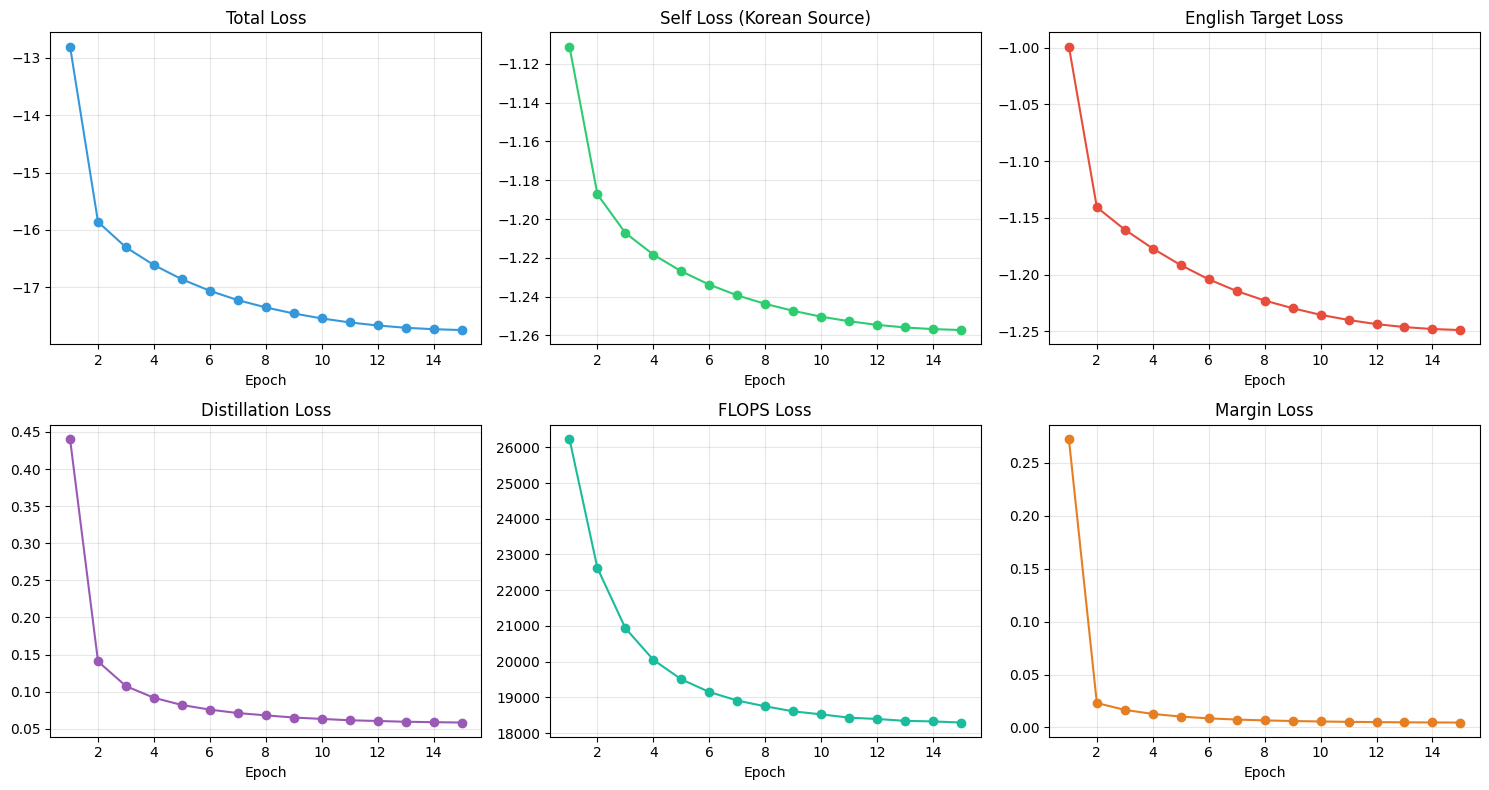

Training curves saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v21_skt_encoder/training_curves.png


: 

In [ ]:
import matplotlib.pyplot as plt

if history:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    epochs = range(1, len(history) + 1)

    axes[0, 0].plot(epochs, [h['total'] for h in history], '-o', color='#3498db')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(epochs, [h['self'] for h in history], '-o', color='#2ecc71')
    axes[0, 1].set_title('Self Loss (Korean Source)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(epochs, [h['en_target'] for h in history], '-o', color='#e74c3c')
    axes[0, 2].set_title('English Target Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].plot(epochs, [h['distill'] for h in history], '-o', color='#9b59b6')
    axes[1, 0].set_title('Distillation Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(epochs, [h['flops'] for h in history], '-o', color='#1abc9c')
    axes[1, 1].set_title('FLOPS Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].plot(epochs, [h['margin'] for h in history], '-o', color='#e67e22')
    axes[1, 2].set_title('Margin Loss')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(CONFIG["output_dir"] / "training_curves.png", dpi=150)
    plt.show()
    
    print(f"Training curves saved to: {CONFIG['output_dir'] / 'training_curves.png'}")

## Summary

### v21 Model Architecture

| Component | v19 | v21 |
|-----------|-----|-----|
| Base Model | xlm-roberta-large | **skt/A.X-Encoder-base** |
| Parameters | 560M | ~110M |
| Vocab Size | 250,002 | **50,000** |
| Korean Support | Multilingual | **Korean-optimized** |
| Teacher | BGE-M3 | BGE-M3 |

### Why skt/A.X-Encoder-base?

1. **Korean-optimized vocabulary**: Better tokenization for Korean text
2. **Smaller vocabulary**: 50K vs 250K → smaller sparse vectors
3. **Efficient**: ~5x smaller model with similar performance
4. **Bilingual**: Native Korean-English support

### Next Steps

1. Run `03_inference_test.ipynb` to evaluate the model
2. Compare with v19 xlm-roberta-large baseline
3. Analyze Korean token preservation